In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

In [3]:
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# lade die MNIST-Dataset herunter, und lade sie in DataLoader von pytorch, in batchsize von 64
data_path="./data"
trainset = datasets.MNIST(data_path, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# lade validationset für testen nach training
valset = datasets.MNIST(data_path, download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)


In [4]:
# erstelle ein iterator von der Traindaten, und nehme eine batch von images und deren labels
dataiter = iter(trainloader)
images, labels = dataiter.next()
# hier steht dass wir ein batch von 64 images haben, und jede image hat eine Dimension von 28*28 = 784
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


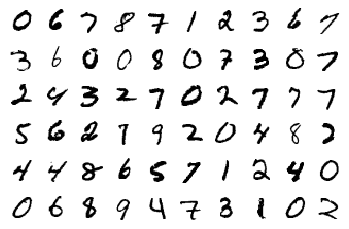

In [5]:
# plotten wir züfällige images aus Dataset zur Einsicht
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
# erstelle mithilfe von torch.nn ein Model, mit 784 input neuronen,
# 128 neuronen im ersten hidden layer, und 64 im zweiten
# mit ReLU Funktion als Aktivierungsfunktion für beide hidden Layern
# 10 neuronen im output layer, entsprechend die Zahlen von 0-9, LogSoftmax als Aktivierungsfunktion
# LogSoftmax ist einfach der Logarithmus des Softmax, und normalisiert die outputwerte so ,dass die Summe davon 1 ergibt
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
time0 = time()
epochs = 15
loss_history=[]
for e in range(epochs):
    # der loss für die aktuelle Trainingsepoch auf 0 resetten
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        # vergeich outputswerte mit der labels
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        print("Training Time (in minutes) =",(time()-time0)/60, "\n")
    loss_history.append(running_loss)   

/home/nader/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch 0 - Training loss: 0.3774607049773878
Training Time (in minutes) = 0.14090030988057453 

Epoch 1 - Training loss: 0.24220323330486443
Training Time (in minutes) = 0.2877513527870178 

Epoch 2 - Training loss: 0.22848552677220405
Training Time (in minutes) = 0.42898505528767905 

Epoch 3 - Training loss: 0.22549352850884136
Training Time (in minutes) = 0.5695558071136475 

Epoch 4 - Training loss: 0.20784402370993008
Training Time (in minutes) = 0.7086116393407186 

Epoch 5 - Training loss: 0.2111752514890246
Training Time (in minutes) = 0.8473818858464559 

Epoch 6 - Training loss: 0.20289749283093347
Training Time (in minutes) = 0.988218343257904 

Epoch 7 - Training loss: 0.19601624425071706
Training Time (in minutes) = 1.1506827314694723 

Epoch 8 - Training loss: 0.19253975196457557
Training Time (in minutes) = 1.3104259014129638 

Epoch 9 - Training loss: 0.18454712323560468
Training Time (in minutes) = 1.4527255296707153 

Epoch 10 - Training loss: 0.18267419270382745
Train

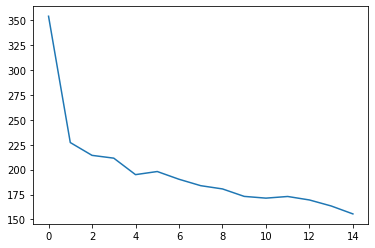

In [8]:
fig = plt.figure()
plt.plot(loss_history)
plt.show()

In [9]:
def view_classify(img, ps):
    # Function for viewing an image and it's predicted classes.
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 6


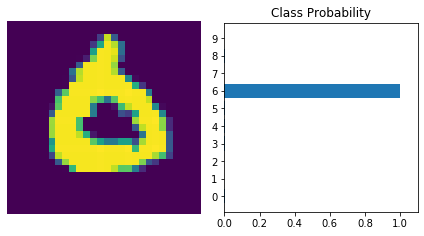

In [10]:
images, labels = next(iter(valloader))
img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [11]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9519


In [12]:
torch.save(model, './my_mnist_model.pt') 

Quellen
https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627